## Lab 4: An RNN for Sentiment Analysis

Sentiment Analysis is the problem of identifying the writer's sentiment given a piece of text. Sentiment Analysis can be applied to movie reviews, feedback of other forms, emails, tweets, course evaluations, and much more.

Rudimentary forms of sentiment analysis might involve scoring each word on a scale from "sad" to "happy", then averaging the "happiness score" of each word in a piece of text. This technique has obvious drawbacks: it won't be able to handle negation, sarcasm, or any complex syntactical form. We can do better.

In this lab, we will use a recurrent neural network to classify the sentiment of a piece of text (a sequence of words). We'll use GloVe embeddings as inputs to the recurrent network. As a sidenote, not all recurrent neural networks use word embeddings as input. If we had a small enough vocabulary, we could have used a one-hot embedding of the words.

### Data

We'll focus on the problem of classifying tweets as having positive or negative emotions. We use the Sentiment140 dataset, which contains tweets with either a positive or negative emoticon. Our goal is to determine whether which type of emoticon the tweet (with the emoticon removed) contained. You can download the data from here:
https://www.dropbox.com/scl/fo/44ci8lvbih0muypomo11e/h?rlkey=3wmoczq5rv6lpocf7htc11ibi&dl=0

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's look at the data:

In [27]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

def get_data():
    # This is a very large file, so we will not load it into RAM
    return csv.reader(open("/content/drive/MyDrive/Lab4_data/training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))

for i, line in enumerate(get_data()):
    if i > 10:
        break
    print(line)

['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467810917', 'Mon Apr 06 22:19:53 PDT 2009', 'NO_QUERY', 'mattycus', '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds']
['0', '1467811184', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'ElleCTF', 'my whole body feels itchy and like its on fire ']
['0', '1467811193', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'Karoli', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
['0', '1467811372', 'Mon Apr 06 22:20:00 PDT 2009', 'NO_QUERY', 'joy_wolf', '@Kwesidei not the whole crew ']
['0', '14

The columns we care about is the first one and the last one. The first column is the label (the label 0 means "sad" tweet, 4 means "happy" tweet), and the last column contains the tweet. Our task is to predict the sentiment of the tweet given the text.

### Data Preprocessing

We will need to split the text into words. We will do so by splitting at all whitespace characters. There are better ways to perform the split, but let's keep our dependencies light.

In [28]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

Since tweets often have mispellings, we'll need to ignore words that do not appear in the Glove embeddings. Let's sanity check that there are enough words for us to work with.

Need to make sure that each tweet has at least a few words that have an embedding.

In [29]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

for i, line in enumerate(get_data()):
    if i > 30:
        break
    print(sum(int(w in glove.stoi) for w in split_tweet(line[-1])))

21
23
17
10
22
4
3
21
4
3
9
4
19
15
19
18
18
4
9
13
11
23
8
9
4
11
13
6
23
20
13


### Training Data

We will only use 1/29  of the data in the file, so that our initial development runs relatively quickly. Later, once everything is debugged and working, we should use the whole dataset.

Since we are going to store the individual words in a tweet, we will defer looking up the word embeddings. Instead, we will store the index of each word in a PyTorch tensor. Our choice is the most memory-efficient, since it takes fewer bits to store an integer index than a 50-dimensional vector or a word.

In [30]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        if i % 29 == 0:
            tweet = line[-1]
            ### SOLUTION BEGIN
            idxs = [glove_vector.stoi[w] for w in split_tweet(tweet) if w in glove_vector.stoi]  # lookup the index of word, keep words that has an embedding
            ### SOLUTION END
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(line[0] == "4")).long()
            if i % 5 < 3:
                train.append((idxs, label))
            elif i % 5 == 4:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)

Here's what an element of the training set looks like:

In [31]:
tweet, label = train[0]
print(tweet)
print(label)

tensor([     2,     11, 190100,      1,      7,  70483,      2,     81, 107356,
           405,    684,   9912,      3,    245,    122,      4,     88,     20,
             2,     89,   1968])
tensor(0)


Each element of the training set will have a different shape. We will have to be careful to handle these differences when we batch the data.

In [32]:
for i in range(10):
    tweet, label = train[i]
    print(tweet.shape)

torch.Size([21])
torch.Size([26])
torch.Size([9])
torch.Size([23])
torch.Size([7])
torch.Size([5])
torch.Size([10])
torch.Size([10])
torch.Size([7])
torch.Size([31])


### Embedding

We are also going to use an `nn.Embedding` layer, instead of using the variable glove directly. The reason is that the `nn.Embedding` layer lets us look up the embeddings of multiple words simultaneously, so that our network can make predictions and train faster:

In [33]:
# Create an `nn.Embedding` layer and load data from pretrained `glove.vectors`

### SOLUTION BEGIN
glove_emb = nn.Embedding.from_pretrained(glove.vectors)
### SOLUTION END

# Example: we use the forward function of glove_emb to lookup the
# embedding of each word in `tweet`
tweet_emb = glove_emb(tweet)
tweet_emb.shape

torch.Size([31, 50])

### Recurrent Neural Network Module

PyTorch has variations of recurrent neural network modules. These modules computes the following:

    hidden=updatefn(hidden,input)
    output=outputfn(hidden)

Let's take a look at an RNN module:

In [34]:
# Build the RNN Layer
rnn_layer = nn.RNN(input_size=50, hidden_size=50, batch_first=True)  # dimension of the input repr
                 # dimension of the hidden units
                 # input format is [batch_size, seq_len, repr_dim]

Now, let's try and run this untrained `rnn_layer` on `tweet_emb`. We will need to add an extra dimension to `tweet_emb` to account for batching. We will also need to initialize a set of hidden units of size `[batch_size, 1, repr_dim]`, to be used for the first set of computations.

In [35]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
h0 = torch.zeros(1, 1, 50)           # initial hidden state (optional)
out, last_hidden = rnn_layer(tweet_input, h0)

We don't technically have to explictly provide the initial hidden state, if we want to use an initial state of zeros. This code does the exact same thing as the previous line of code:

In [36]:
out2, last_hidden2 = rnn_layer(tweet_input)

Now, let's look at the output and hidden dimensions that we have:

In [37]:
print(out.shape)
print(last_hidden.shape)

torch.Size([1, 31, 50])
torch.Size([1, 1, 50])


The shape of the variable `last_hidden` is the same as our initial `h0`. The variable out contains the hidden (context) units across all time steps (i.e. each word in the tweet).

If we only care about the output at the **final** time point, we can use `last_hidden` as the embedding of the entire tweet. Alternatively, we can extrat `last_hidden` like this:

In [38]:
print(last_hidden)
print(out[:,-1,:]) # should be the same

tensor([[[ 0.1854, -0.0638,  0.3235, -0.4899,  0.1017, -0.1116,  0.4901,
          -0.5096, -0.7065, -0.0062,  0.1339, -0.4691,  0.1160,  0.2750,
          -0.7884, -0.3717, -0.2038, -0.3880,  0.4195, -0.1877,  0.5482,
          -0.5071,  0.1137, -0.3141, -0.1970,  0.6535, -0.4641, -0.1955,
           0.2585, -0.3312, -0.2380, -0.1707, -0.0302,  0.2163, -0.0222,
          -0.2926,  0.2100, -0.2411, -0.6383, -0.5433, -0.6349, -0.3738,
          -0.1324,  0.2656, -0.0470, -0.5927, -0.4471, -0.6085, -0.6881,
          -0.0724]]], grad_fn=<StackBackward0>)
tensor([[ 0.1854, -0.0638,  0.3235, -0.4899,  0.1017, -0.1116,  0.4901, -0.5096,
         -0.7065, -0.0062,  0.1339, -0.4691,  0.1160,  0.2750, -0.7884, -0.3717,
         -0.2038, -0.3880,  0.4195, -0.1877,  0.5482, -0.5071,  0.1137, -0.3141,
         -0.1970,  0.6535, -0.4641, -0.1955,  0.2585, -0.3312, -0.2380, -0.1707,
         -0.0302,  0.2163, -0.0222, -0.2926,  0.2100, -0.2411, -0.6383, -0.5433,
         -0.6349, -0.3738, -0.1324, 

This tensor above is a representation of the entire tweet, and can be used as an input to a classifier.

### Building a Model

Let's put both the embedding layer, the RNN and the classifier into one model:

In [39]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = TweetRNN(50, 50, 2)

We'll be able to extract a prediction from this model like this:

In [40]:
tweet, label = train[0]
tweet = tweet.unsqueeze(0) # add a batch dimension
model(tweet)

tensor([[0.2543, 0.2928]], grad_fn=<AddmmBackward0>)

At this point, we should be able to train this model similarly to any other neural network: we have specified a forward-pass computation, we know what loss function to use for a classification problem, and we can use an optimizer of our choice to optimize the weights.

However, there is one other hurdle we need to jump over that is specific to RNN's: batching.

### Batching

Unfortunately, we will not be able to use `DataLoader` with a `batch_size`  greater than one. This is because each tweet has a different shaped tensor.

PyTorch implementation of `DataLoader` class expects all data samples to have the same shape. So, if we create a `DataLoader` like below, it will throw an error when we try to iterate over its elements.

In [41]:
#will_fail = torch.utils.data.DataLoader(train, batch_size=128)
#for elt in will_fail:
#    print("ok")

So, we will need a different way of batching.

One strategy is to pad shorter sequences with zero inputs, so that every sequence is the same length. The following PyTorch utilities are helpful.

- `torch.nn.utils.rnn.pad_sequence`
- `torch.nn.utils.rnn.pad_packed_sequence`
- `torch.nn.utils.rnn.pack_sequence`
- `torch.nn.utils.rnn.pack_padded_sequence`

(Actually, there are more powerful helpers in the `torchtext` module that we might use later. We'll stick to these in this lab, so that you can see what's actually going on under the hood.)

In [42]:
from torch.nn.utils.rnn import pad_sequence

tweet_padded = pad_sequence([tweet for tweet, label in train[:10]], batch_first=True)

tweet_padded.shape

torch.Size([10, 31])

In [43]:
tweet_padded

tensor([[     2,     11, 190100,      1,      7,  70483,      2,     81, 107356,
            405,    684,   9912,      3,    245,    122,      4,     88,     20,
              2,     89,   1968,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0],
        [   192,  57251,  11567,      2,     41,   4284,     83,      0,  38904,
             31,   1096,      4,     88,     17,     20,    188,     83,    100,
              1,    500,      1,     41,    169,     20,      1,    837,      0,
              0,      0,      0,      0],
        [  8738,  34849,     34,     41,    346,     41,   1346,      7,   1019,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0],
        [    41,    149,   1465,      0,     89,   3630,   4242,  16522,   4798,
          21549,    116,    285,   7033,     22,      0,    156,

Now, we can pass multiple tweets in a batch through the RNN at once!

In [44]:
out = model(tweet_padded)
out.shape

torch.Size([10, 2])

One issue we overlooked was that in our `TweetRNN` model, we always take the last output unit as input to the final classifier. Now that we are padding the input sequences, we should really be using the output at a previous time step. Recurrent neural networks require much more record keeping than MLPs or even CNNs.

There is yet another problem: the longest tweet has many, many more words than the shortest. Padding tweets so that every tweet has the same length as the longest tweet is impractical. Padding tweets in a mini-batch, however, is much more reasonable.

In practice, practitioners will batch together tweets with the same length. For simplicity, we will do the same. We will implement a (more or less) straightforward way to batch tweets.

In [45]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)

        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}

    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

Let's take a look at our batcher in action. We will set `drop_last` to be true for training, so that all of our batches have exactly the same size.

In [46]:
for i, (tweets, labels) in enumerate(TweetBatcher(train, drop_last=True)):
    if i > 5: break
    print(tweets.shape, labels.shape)

torch.Size([32, 13]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 9]) torch.Size([32])
torch.Size([32, 26]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 5]) torch.Size([32])


Here is a `get_accuracy` function we need to verify our code

In [47]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

test_loader = TweetBatcher(test, batch_size=32, drop_last=False)
get_accuracy(model, test_loader)

0.5022785271600437

Our training code is pretty standard...

In [48]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Let's train our model. Note that there will be some inaccuracies in computing the training loss. We are dropping some data from the training set by setting drop_last=True. Again, the choice is not ideal, but simplifies our code.

Epoch 1; Loss 0.588510; Train Acc 0.666866; Val Acc 0.665512
Epoch 2; Loss 0.563689; Train Acc 0.676065; Val Acc 0.674995
Epoch 3; Loss 0.588360; Train Acc 0.679908; Val Acc 0.677275
Epoch 4; Loss 0.541277; Train Acc 0.677167; Val Acc 0.673901
Epoch 5; Loss 0.600249; Train Acc 0.683531; Val Acc 0.679555
Epoch 6; Loss 0.581836; Train Acc 0.688004; Val Acc 0.683294
Epoch 7; Loss 0.653734; Train Acc 0.687626; Val Acc 0.685026
Epoch 8; Loss 0.591788; Train Acc 0.674679; Val Acc 0.675451
Epoch 9; Loss 0.595323; Train Acc 0.688981; Val Acc 0.688492
Epoch 10; Loss 0.546302; Train Acc 0.689768; Val Acc 0.690407
Epoch 11; Loss 0.687627; Train Acc 0.688099; Val Acc 0.684570
Epoch 12; Loss 0.568017; Train Acc 0.692131; Val Acc 0.693690
Epoch 13; Loss 0.540820; Train Acc 0.692194; Val Acc 0.689677
Epoch 14; Loss 0.673563; Train Acc 0.694745; Val Acc 0.693872
Epoch 15; Loss 0.578898; Train Acc 0.694273; Val Acc 0.692869
Epoch 16; Loss 0.550958; Train Acc 0.695691; Val Acc 0.696061
Epoch 17; Loss 0.

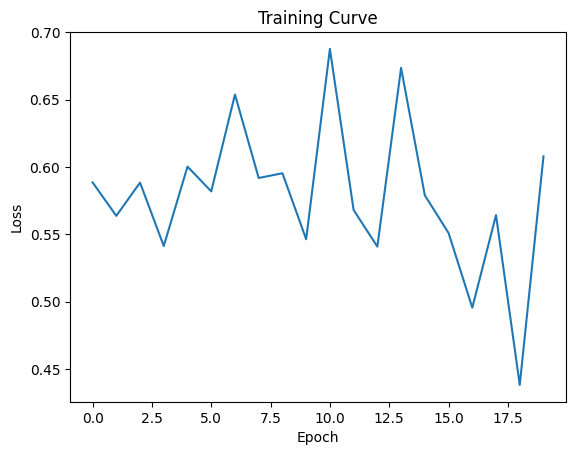

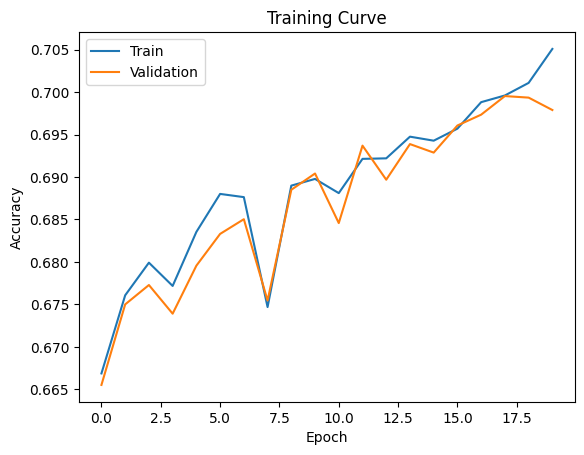

0.7014218009478673

In [49]:
model = TweetRNN(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)

The hidden size and the input embedding size don't have to be the same. Do we get better results from the network below?  Would the use of the complete dataset improve the accuracy?

Epoch 1; Loss 0.571500; Train Acc 0.663180; Val Acc 0.667974
Epoch 2; Loss 0.582815; Train Acc 0.675907; Val Acc 0.675816
Epoch 3; Loss 0.635339; Train Acc 0.679940; Val Acc 0.678370
Epoch 4; Loss 0.533810; Train Acc 0.681452; Val Acc 0.678187
Epoch 5; Loss 0.633466; Train Acc 0.678648; Val Acc 0.678825
Epoch 6; Loss 0.579113; Train Acc 0.683814; Val Acc 0.686486
Epoch 7; Loss 0.569859; Train Acc 0.681326; Val Acc 0.681470
Epoch 8; Loss 0.625417; Train Acc 0.685232; Val Acc 0.685026
Epoch 9; Loss 0.589271; Train Acc 0.680349; Val Acc 0.679920
Epoch 10; Loss 0.562504; Train Acc 0.688067; Val Acc 0.687306
Epoch 11; Loss 0.559424; Train Acc 0.691375; Val Acc 0.690316
Epoch 12; Loss 0.680595; Train Acc 0.680318; Val Acc 0.678370
Epoch 13; Loss 0.563969; Train Acc 0.693674; Val Acc 0.688856
Epoch 14; Loss 0.552894; Train Acc 0.692666; Val Acc 0.686759
Epoch 15; Loss 0.575633; Train Acc 0.695911; Val Acc 0.690771
Epoch 16; Loss 0.680932; Train Acc 0.700888; Val Acc 0.694419
Epoch 17; Loss 0.

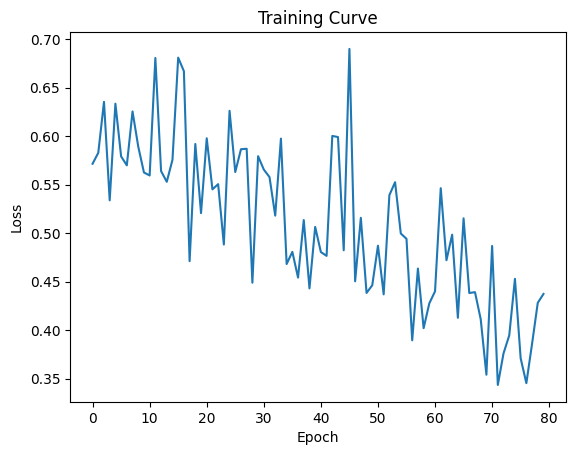

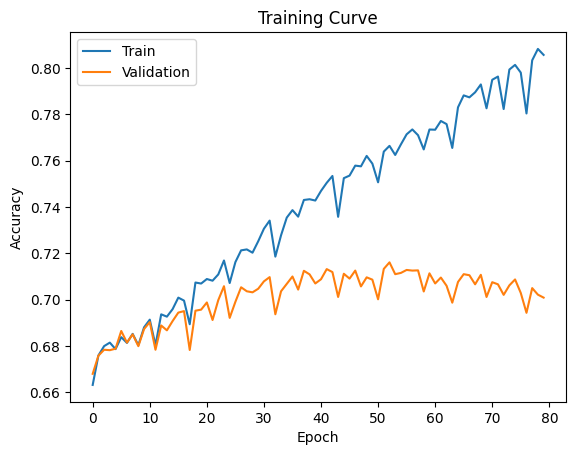

0.710262486328837

In [50]:
model = TweetRNN(50, 100, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=80, learning_rate=2e-4)
get_accuracy(model, test_loader)

### LSTM for Long-Term Dependencies

There are variations of recurrent neural networks that are more powerful. One such variation is the Long Short-Term Memory (LSTM) module. An LSTM is like a more powerful version of an RNN that is better at perpetuating long-term dependencies. Instead of having only one hidden state, an LSTM keeps track of both a hidden state and a cell state.

In [51]:
lstm_layer = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)

This is how we can feed this tweet into the LSTM, similar to what we tried with the RNN earlier.

In [52]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension --> (1, sequence_length, embedding_dimension)
h0 = torch.zeros(1, 1, 50)     # initial hidden layer
c0 = torch.zeros(1, 1, 50)     # initial cell state
out, last_hidden = lstm_layer(tweet_input, (h0, c0))
out.shape # (1, sequence_length, hidden_size)

torch.Size([1, 31, 50])

So an LSTM version of our model would look like this:

Epoch 1; Loss 0.686228; Train Acc 0.578125; Val Acc 0.578698
Epoch 2; Loss 0.688132; Train Acc 0.610289; Val Acc 0.608517
Epoch 3; Loss 0.665820; Train Acc 0.629599; Val Acc 0.629582
Epoch 4; Loss 0.691999; Train Acc 0.648091; Val Acc 0.657396
Epoch 5; Loss 0.620117; Train Acc 0.660503; Val Acc 0.667335
Epoch 6; Loss 0.583113; Train Acc 0.665669; Val Acc 0.670618
Epoch 7; Loss 0.651244; Train Acc 0.668945; Val Acc 0.675451
Epoch 8; Loss 0.609584; Train Acc 0.671402; Val Acc 0.675907
Epoch 9; Loss 0.621107; Train Acc 0.672915; Val Acc 0.679373
Epoch 10; Loss 0.619793; Train Acc 0.676033; Val Acc 0.682017
Epoch 11; Loss 0.621529; Train Acc 0.676884; Val Acc 0.682838
Epoch 12; Loss 0.626530; Train Acc 0.677892; Val Acc 0.684388
Epoch 13; Loss 0.593364; Train Acc 0.680223; Val Acc 0.684023
Epoch 14; Loss 0.545291; Train Acc 0.682397; Val Acc 0.684479
Epoch 15; Loss 0.650294; Train Acc 0.682995; Val Acc 0.685391
Epoch 16; Loss 0.632997; Train Acc 0.684192; Val Acc 0.684935
Epoch 17; Loss 0.

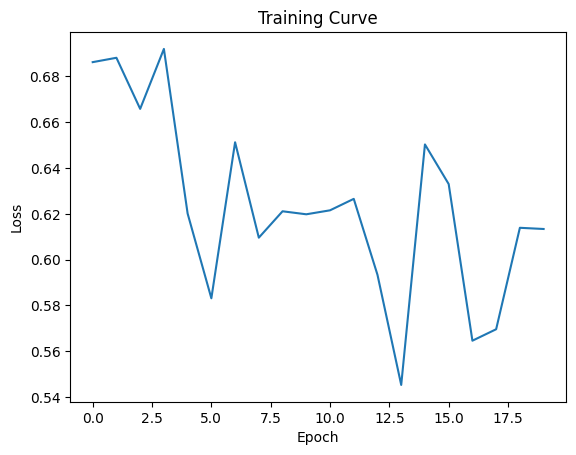

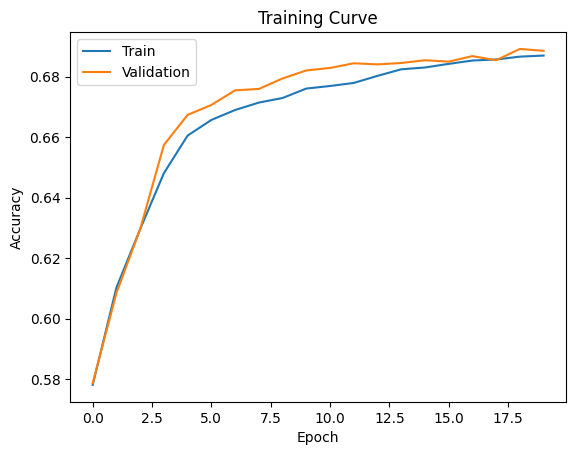

0.6848341232227488

In [53]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x,(h0,c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model_lstm = TweetLSTM(50, 50, 2)
train_rnn_network(model_lstm, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
get_accuracy(model_lstm, test_loader)

Again, increasing the size of the hidden layer and using the whole tweet dataset could improve the sentiment analysis prediction. Try it!

### GRU for Long-Term Dependencies

Another variation of an RNN is the Gated-Recurrent Unit (GRU). The GRU was invented after LSTM, and is intended to be a simplification of the LSTM that is still just as powerful. The nice thing about GRU units is that they have only one hidden state.

In [54]:
gru_layer = nn.GRU(input_size=50, hidden_size=50, batch_first=True)

The GRU API is virtually identical to that of the vanilla RNN:

In [55]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
h0 = torch.zeros(1, 1, 50)     # initial hidden layer
out, last_hidden = gru_layer(tweet_input, h0)
out.shape

torch.Size([1, 31, 50])

So a GRU version of our model would look similar to before:

Epoch 1; Loss 0.691040; Train Acc 0.512002; Val Acc 0.509393
Epoch 2; Loss 0.685772; Train Acc 0.568958; Val Acc 0.567664
Epoch 3; Loss 0.665725; Train Acc 0.603012; Val Acc 0.605052
Epoch 4; Loss 0.669293; Train Acc 0.623677; Val Acc 0.628123
Epoch 5; Loss 0.649732; Train Acc 0.636435; Val Acc 0.643626
Epoch 6; Loss 0.632905; Train Acc 0.647713; Val Acc 0.656392
Epoch 7; Loss 0.623871; Train Acc 0.660377; Val Acc 0.667974
Epoch 8; Loss 0.702673; Train Acc 0.668378; Val Acc 0.673536
Epoch 9; Loss 0.701652; Train Acc 0.670898; Val Acc 0.675999
Epoch 10; Loss 0.537452; Train Acc 0.673198; Val Acc 0.678005
Epoch 11; Loss 0.582029; Train Acc 0.674868; Val Acc 0.679829
Epoch 12; Loss 0.604901; Train Acc 0.677577; Val Acc 0.681288
Epoch 13; Loss 0.677251; Train Acc 0.678144; Val Acc 0.681926
Epoch 14; Loss 0.600085; Train Acc 0.678427; Val Acc 0.683567
Epoch 15; Loss 0.594088; Train Acc 0.679971; Val Acc 0.684297
Epoch 16; Loss 0.620682; Train Acc 0.680727; Val Acc 0.687397
Epoch 17; Loss 0.

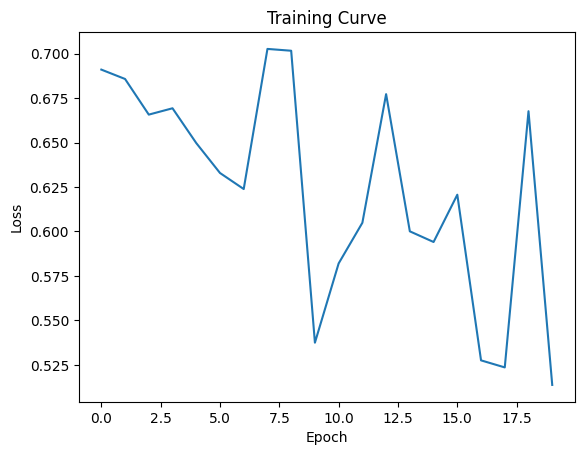

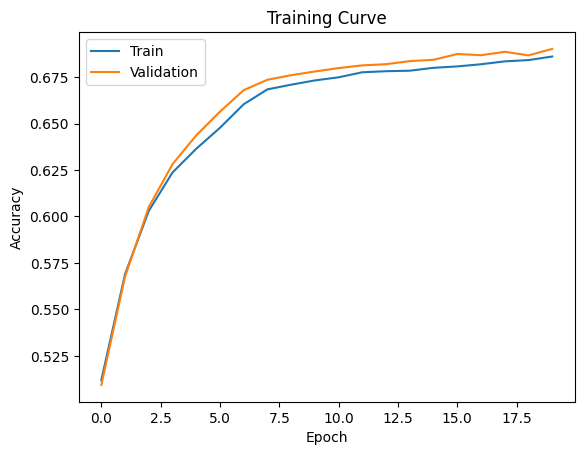

0.6862923806051768

In [56]:
class TweetGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetGRU, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the GRU
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model_gru = TweetGRU(50, 50, 2)
train_rnn_network(model_gru, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
get_accuracy(model_gru, test_loader)